PROJECT-3. Анализ воронки

ЦЕЛЬ ПРОЕКТА:
Исследовать поведение пользователей в обновлённом приложении Quiz Freeze.

ЗАДАЧИ:

1. Определить, насколько обучение сокращает время прохождения этапов игры.
2. Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.
3. Определить, насколько прозрачен процесс взаимодействия с игрой.

ПРЕДВАРИТЕЛЬНАЯ РАБОТА С ДАННЫМИ:

In [254]:
#Загружаем библиотеки и датасеты, оставляем данные только за 2018 год:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

events_df = pd.read_csv('7_4_Events.csv', sep=',')
purchase_df = pd.read_csv('purchase.csv', sep=',')

events_df['start_time']=pd.to_datetime(events_df['start_time'], errors = 'coerce')
purchase_df['event_datetime']=pd.to_datetime(purchase_df['event_datetime'], errors = 'coerce')
mask1 = (events_df['start_time'] >= '2018-01-01') & (events_df['start_time'] < '2019-01-01') & (events_df['event_type']=='registration')
users_2018 = events_df[mask1]['user_id'].to_list()
events_df = events_df[events_df['user_id'].isin(users_2018)]

In [255]:
#Добавляем в датафрейм purchase_df столбец event_type со значением purchase:

purchase_df['event_type'] = 'purchase'

In [256]:
#Изменяем название столбцов:

events_df = events_df.rename(columns={"id": "event_id"})
purchase_df = purchase_df.rename(columns={"id": "purchase_id", "event_datetime": "start_time"})

In [257]:
#Объединяем датафреймы:

total_events_df = pd.concat([events_df,purchase_df],sort=False)

ПРОВЕРКА ГИПОТЕЗЫ №1:
"По идее, должна быть разница в поведении групп, которые проходят и не проходят обучение. Но так ли это? Влияет ли обучение на скорость прохождения других этапов игры?"

Сравниваем время прохождения различных этапов для пользователей, которые завершили обучение, и пользователей, не начинавших обучение.

In [258]:
#Создаем группы пользователей по типу событий:

#пользователи, начавшие обучение
tutorial_start_users = total_events_df[total_events_df["event_type"] == "tutorial_start"][
    "user_id"
].unique()
tutorial_start_users= set(tutorial_start_users)

#пользователи, закончившие обучение
tutorial_finish_users = total_events_df[total_events_df["event_type"] == "tutorial_finish"][
    "user_id"
].unique()
tutorial_finish_users= set(tutorial_finish_users)

In [259]:
#Создаем функцию, разделяющую пользователей на группы:

def users_group(id):
    if id in tutorial_finish_users:
        return 'training_complete'
    elif id in tutorial_start_users:
        return 'training_started'
    else:
        return 'not_training'

In [260]:
#Добавляем столбец с группой пользователя в датафрейм:
total_events_df['users_group'] = total_events_df['user_id'].apply(users_group)

In [261]:
#Создаем сводную таблицу:

time_delta = total_events_df.pivot_table(
    values='start_time',
    index=['user_id', 'users_group'],
    columns='event_type',
    aggfunc=min
)

In [262]:
#Находим промежутки времени и переводим в числовой формат:

time_delta['to_level_choise'] = (time_delta['level_choice'] - time_delta['registration'])/pd.Timedelta('1 hour')
time_delta['to_pack_choise'] = (time_delta['pack_choice'] - time_delta['registration'])/pd.Timedelta('1 hour')
time_delta['to_purchase'] = (time_delta['purchase'] - time_delta['registration'])/pd.Timedelta('1 hour')

In [263]:
#Находим среднее время:

median_time = time_delta.groupby('users_group')['to_level_choise', 'to_pack_choise', 'to_purchase'].median()
display(median_time)

C:\Users\yours\AppData\Local\Temp\ipykernel_11656\183626560.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  median_time = time_delta.groupby('users_group')['to_level_choise', 'to_pack_choise', 'to_purchase'].median()


event_type,to_level_choise,to_pack_choise,to_purchase
users_group,,,
not_training,4.934861,4.768333,107.485833
training_complete,6.001944,6.100972,91.083056
training_started,7.294167,7.530000,101.437222


In [264]:
median_time.reset_index(inplace=True)
median_time.drop(labels = [2],axis = 0, inplace=True)

ДИАГРАММА ПО ГИПОТЕЗЕ №1

Text(0, 0.5, 'Время до покупки')

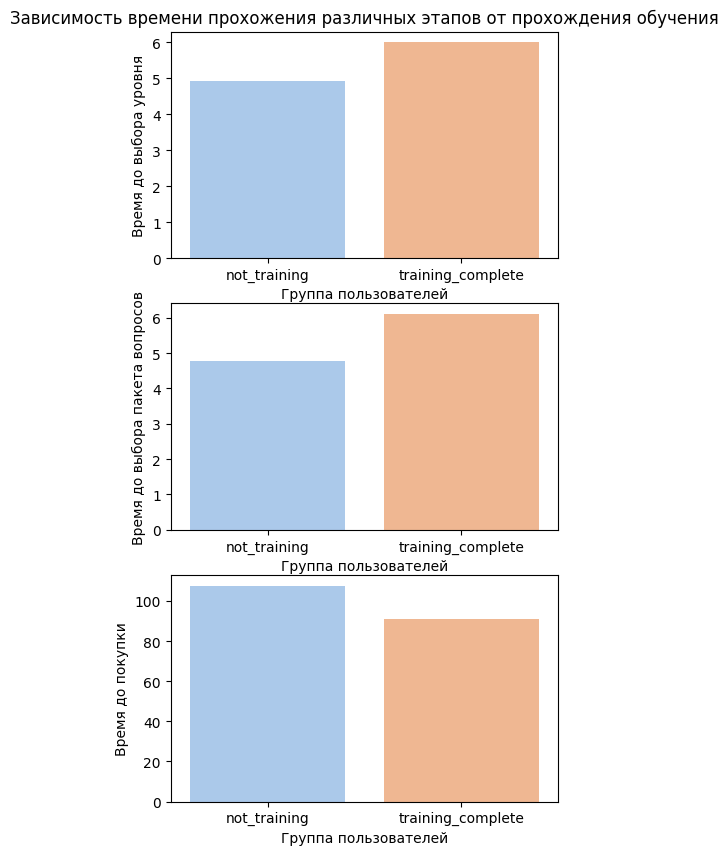

In [265]:
#Строим столбчатую диаграмму, отражающую время прохождения различных этапов для пользователей, 
#которые прошли обучение, и для пользователей, не начинавших обучение:

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5, 10))
barplot_1 = sns.barplot(
    data=median_time,
    x=median_time['users_group'],
    y = median_time['to_level_choise'],
    palette="pastel",
    ax=axes[0]
    );
barplot_2 = sns.barplot(
    data=median_time,
    x=median_time['users_group'],
    y = median_time['to_pack_choise'],
    palette="pastel",
    ax=axes[1]
    );
barplot_3 = sns.barplot(
    data=median_time,
    x=median_time['users_group'],
    y = median_time['to_purchase'],
    palette="pastel",
    ax=axes[2]
    )
barplot_1.set_title('Зависимость времени прохожения различных этапов от прохождения обучения')
barplot_1.set_xlabel('Группа пользователей')
barplot_2.set_xlabel('Группа пользователей')
barplot_3.set_xlabel('Группа пользователей')
barplot_1.set_ylabel('Время до выбора уровня')
barplot_2.set_ylabel('Время до выбора пакета вопросов')
barplot_3.set_ylabel('Время до покупки')


ВЫВОД ПО ГИПОТЕЗЕ №1:
В ходе проверки гипотезы №1 мы выяснили, что пользователи, которые не проходят обучение, быстрее переходят к выбору уровня и пакету вопросов.
При этом пользователи, которые проходят обучение, быстрее переходят к покупке платных вопросов.
Разница в этих показателях минимальна.
Исходя из этого можно сделать вывод, что обучение не сокрашает время прохождения этапов игры, гипотеза не верна.

ПРОВЕРКА ГИПОТЕЗЫ №2
"Кажется, повторное прохождение обучения положительно влияет на оплату, верно?"

Проверяем, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь. 

In [266]:
#Группируем данные для определения, сколько попыток обучения было у каждого пользователя:

tutorial_starts = total_events_df[total_events_df['event_type'] == 'tutorial_start']
tutorial_starts = tutorial_starts.groupby('user_id')['event_type'].value_counts().to_frame()
tutorial_starts_df = pd.DataFrame(tutorial_starts)
tutorial_starts_df.columns = ['starts']
tutorial_starts_df = tutorial_starts.reset_index()
tutorial_starts_df = tutorial_starts_df.drop('event_type', axis=1)
tutorial_starts_df = tutorial_starts_df.merge(purchase_df, how = 'left', on = 'user_id')
tutorial_starts_df = tutorial_starts_df.drop(['start_time', 'event_type'], axis=1)
tutorial_starts_df['amount'] = tutorial_starts_df['amount'].fillna(0)
tutorial_starts_df

,user_id,starts,purchase_id,amount
0,27833,1,NaN,0.0
1,27834,1,NaN,0.0
2,27835,1,NaN,0.0
3,27836,2,NaN,0.0
4,27839,1,NaN,0.0
...,...,...,...,...
11853,47748,1,NaN,0.0
11854,47751,1,NaN,0.0
11855,47753,1,NaN,0.0
11856,47755,1,NaN,0.0


In [267]:
#Создаем группы пользователей по количеству попыток обучения:

number_of_users = tutorial_starts_df.groupby('starts').agg({'user_id': ['count'], 'purchase_id': ['count'], 'amount': ['sum']})
number_of_users_df = pd.DataFrame(number_of_users)
number_of_users_df.columns = ['users', 'clients', 'total_amount']
number_of_users_df = number_of_users_df.reset_index()

#Находим конверсию из пользователей в клиенты для каждой группы:
number_of_users_df['conversion'] = (number_of_users_df['clients'] / number_of_users_df['users'] * 100).round(2)
number_of_users_df

,starts,users,clients,total_amount,conversion
0,1,9103,1207,132475.0,13.26
1,2,1589,218,24950.0,13.72
2,3,427,51,5675.0,11.94
3,4,221,30,2950.0,13.57
4,5,109,16,1950.0,14.68
5,6,116,14,1675.0,12.07
6,7,94,12,1325.0,12.77
7,8,86,13,1350.0,15.12
8,9,113,17,2000.0,15.04


In [268]:
#Находим средний процент коверсии:

mean_conversion = number_of_users_df['conversion'].mean().round(2)
print('Средний процент конверсии среди пользователей, начинавших обучение:', mean_conversion, '%')

Средний процент конверсии среди пользователей, начинавших обучение: 13.57 %


ДИАГРАММА ПО ГИПОТЕЗЕ №2

Text(0, 0.5, 'Конверсия')

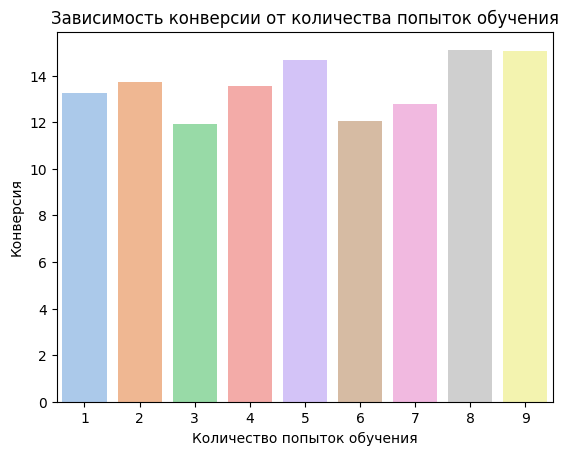

In [269]:
#Строим столбчатую диаграмму, отражающую зависимость конверсии от количества попыток обучения:

barplot_4 = sns.barplot(
    data=number_of_users_df,
    x=number_of_users_df['starts'],
    y = number_of_users_df['conversion'],
    palette="pastel",
    )
barplot_4.set_title('Зависимость конверсии от количества попыток обучения')
barplot_4.set_xlabel('Количество попыток обучения')
barplot_4.set_ylabel('Конверсия')


ВЫВОД ПО ГИПОТЕЗЕ №2: В ходе проверки гипотезы №2 мы выяснили, что процент конверсии по группам пользователей, начинавших проходить обучение разное количество раз, не имеет большого отличия. В среднем процент конверсии составляет 13.57%.
Исходя из этого можем сделать вывод, что количество обучений не влияет на вероятность покупки платных вопросов пользователем, начало прохождения обучения само по себе хорошо влияет на оплату, так как мы имеем высокий средний процент конверсии. Гипотеза не верна.

ПРОВЕРКА ГИПОТЕЗЫ №3
"Если пользователь сначала выбирает сложность обучения, будет ли он потом проходить обучение?"

Определяем, как часто пользователи начинают обучение после выбора уровня сложности. 

In [270]:
#Выделяем датафрейм с выбором уровня сложности:

choices = total_events_df[total_events_df['event_type'] == 'level_choice']
choices = choices.drop(['purchase_id', 'amount', 'users_group', 'selected_level', 'tutorial_id'], axis= 1)
choices.columns = ['level_choice_id', 'level_choice', 'level_choice_time', 'user_id']

In [271]:
#Выделяем датафрейм с началом обучения:

starts = total_events_df[total_events_df['event_type'] == 'tutorial_start']
starts = starts.drop(['purchase_id', 'amount', 'users_group', 'selected_level', 'tutorial_id'], axis= 1)
starts.columns = ['tutorial_start_id', 'tutorial_start', 'tutorial_start_time', 'user_id']

In [272]:
#Объединяем два датафрейма:

merged_df = choices.merge(starts, how = 'inner', on = 'user_id')

In [273]:
#Отнимаем от времени старта обучения время выбора уровня сложности, переводим в числовой формат:

merged_df['time_delta'] = merged_df['tutorial_start_time'] - merged_df['level_choice_time']
merged_df['time_delta'] = merged_df['time_delta']/pd.Timedelta('1 hour')
merged_df

,level_choice_id,level_choice,level_choice_time,user_id,tutorial_start_id,tutorial_start,tutorial_start_time,time_delta
0,80327.0,level_choice,2018-01-01 20:37:22,27835,80316.0,tutorial_start,2018-01-01 15:00:51,-5.608611
1,80331.0,level_choice,2018-01-01 22:37:50,27839,80323.0,tutorial_start,2018-01-01 19:11:36,-3.437222
2,80344.0,level_choice,2018-01-02 05:18:42,27840,80337.0,tutorial_start,2018-01-02 02:07:07,-3.193056
3,80346.0,level_choice,2018-01-02 06:19:18,27845,80338.0,tutorial_start,2018-01-02 03:03:44,-3.259444
4,80346.0,level_choice,2018-01-02 06:19:18,27845,80349.0,tutorial_start,2018-01-02 07:08:00,0.811667
...,...,...,...,...,...,...,...,...
12681,147240.0,level_choice,2018-12-31 09:59:00,47732,147236.0,tutorial_start,2018-12-31 07:14:38,-2.739444
12682,147245.0,level_choice,2018-12-31 12:24:40,47747,147242.0,tutorial_start,2018-12-31 10:21:11,-2.058056
12683,147256.0,level_choice,2018-12-31 22:36:19,47753,147253.0,tutorial_start,2018-12-31 20:54:56,-1.689722
12684,147265.0,level_choice,2019-01-01 05:04:52,47755,147260.0,tutorial_start,2019-01-01 00:08:14,-4.943889


In [274]:
#Находим количество пользователей, которые начинали проходить обучение несколько раз(положительные значения time_delta):

users_df = merged_df[merged_df['time_delta'] > 0]
few_tutorials_users = users_df.groupby('user_id')['user_id'].nunique().count()
print('Количество пользователей, которые начинали проходить обучение несколько раз:', few_tutorials_users, 'человек')


Количество пользователей, которые начинали проходить обучение несколько раз: 1386 человек


In [275]:
#Находим общее количество пользователей, которые выбирали уровень сложности:

level_chosen_users = choices.groupby('user_id')['user_id'].nunique().count()
level_chosen_users
print('Количество пользователей, которые выбирали уровень сложности:', level_chosen_users, 'человек')

Количество пользователей, которые выбирали уровень сложности: 8342 человек


In [276]:
#Находим процент пользователей, которые начинали проходить обучение несколько раз, от пользователей, которые выбирали уровень сложности:

percent_of_users = (few_tutorials_users / level_chosen_users * 100).round(2)
print('Процент пользователей, которые начинали проходить обучение несколько раз, от пользователей, которые выбирали уровень сложности:', percent_of_users,'%')


Процент пользователей, которые начинали проходить обучение несколько раз, от пользователей, которые выбирали уровень сложности: 16.61 %


ВЫВОД ПО ГИПОТЕЗЕ №3:
В ходе проверки гипотезы №3 мы выяснили, что не так много пользователей начинают проходить обучение после выбора уровня сложности, всего 16.61%.
Процесс взаимодействия с игрой довольно прозрачный, большинству пользователей понятна работа с приложением.